In [1]:
from nd2shrink.transform import to_8bits

In [27]:
from nd2_combine import tools
from segment import segment
from droplet_growth import multiwell
import numpy as np
import logging
import os
import math
from skimage.transform import rotate
import json
from functools import reduce


logging.basicConfig(level=logging.DEBUG)

logger = logging.getLogger()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
path = r"Z:\Sebastien\mESC_aggregates\SUMO\23_01_2020\D_5\Chip_1.nd2"

In [2]:
path = '/Volumes/Multicell/Sebastien/mESC_aggregates/SUMO/23_01_2020/D_5/Chip_1.nd2'

In [5]:
fluo_path_8001 = '/Volumes/Multicell/Sebastien/mESC_aggregates/SUMO/SUMOICC/8001.nd2'
assert os.path.exists(fluo_path_8001)

In [6]:
fluo_path_1_2 = '/Volumes/Multicell/Sebastien/mESC_aggregates/SUMO/SUMOICC/1-2.nd2'

In [3]:
dirr = path.replace('.nd2','')
try:
    os.mkdir(dirr)
except FileExistsError:
    pass

In [15]:
def to_rgb(stack, order):
    stack8 = to_8bits(stack)
#     print(stack8.shape, stack8.dtype)
    ch = {'r': 'TRITC', 'g': 'FITC', 'b': 'DAPI'}
    rgb = np.stack([stack8[order.index(v)] for v in ch.values()], axis=-1)
#     print(rgb.shape)
#     multiwell.show(rgb)
    

In [16]:
class MultiColorWell:
    def __init__(self, stack_cyx:np.ndarray, 
                 order:list, colors={'r': 'TRITC', 'g': 'FITC', 'b': 'DAPI'}):
        stack = stack_cyx
        assert stack.ndim == 3
        self.original_stack = stack
        assert [color in order for color in colors.values()]
        stack_order = [order.index(v) for v in colors.values()]
        self.colors = colors
        self.rgb = np.stack(to_8bits(stack)[stack_order], axis=-1)
        
    def __repr__(self):
        multiwell.show(self.rgb)
        multiwell.plt.title(self.colors)
        multiwell.plt.show()
        return f'rgb {self.rgb.shape}'
                        
        
        

In [17]:
# from pims_nd2 import ND2_Reader as nd
from nd2reader import ND2Reader as nd

def read_nd2(path:str, bundle_axes='yx', pos_limit=None, well_index=None):
    logger.debug(f'read_nd2: open {path}')
    with nd(path,) as frames:
        print(frames.sizes)
        channels = frames.metadata['channels']
        print(channels)
        px_size_um = frames.metadata['pixel_microns']
        frames.iter_axes = 'v'
        frames.default_coords['z'] = 0
        frames.bundle_axes = bundle_axes
#         if well_index is not None:
#             yield frames[well_index]
#         else:
        for f in frames:
            yield f#MultiColorWell(f, channels)

In [18]:
from pims_nd2 import ND2_Reader as nd
# from nd2reader import ND2Reader as nd

def read_nd2(path:str, bundle_axes='yx', pos_limit=None, well_index=None):
    logger.debug(f'read_nd2: open {path}')
    with nd(path,) as frames:
        print(frames.sizes)
        channels = [
            frames.metadata[f'plane_{i}']['name'] for i in range(
                frames.sizes['c']
            )
        ]
        print(channels)
        px_size_um = frames.calibration
        frames.iter_axes = 'm'
        frames.bundle_axes = bundle_axes
        for f in frames:
            yield MultiColorWell(f, channels)

In [299]:
def filter_regions(r, maj_len=(500, 250), ecc=(0.4, 0.4), convex_area_tolerance=.1):
    return   (r.major_axis_length > maj_len[0] - maj_len[1] and 
              r.major_axis_length < maj_len[0] + maj_len[1] and
              r.eccentricity > ecc[0] - ecc[1] and
              r.eccentricity < ecc[0] + ecc[1] and
              r.convex_area - r.area < r.area * convex_area_tolerance
             )


def get_intensity(mask, intensity_image):
    props = multiwell.regionprops(
        mask,
        intensity_image=intensity_image
    )
#     print(f'MALs: {[p.major_axis_length for p in props]}')
#     print(f'eccs: {[p.eccentricity for p in props]}')
    f_props = list(filter(filter_regions, props))
    print(f'{len(f_props)} after filtering')
    return f_props


def decompose_RGB(rgb_stack):
    tritc = rgb_stack.rgb[:,:,0]
    fitc = rgb_stack.rgb[:,:,1]
    dapi = rgb_stack.rgb[:,:,2]
    return tritc, fitc, dapi
    

def segment_multichannel(rgb_stack:MultiColorWell):
    
    tritc, fitc, dapi = decompose_RGB(rgb_stack)
    
    segs = segment_bf(dapi, thr=0.15, smooth=10, erode=20)
    
    crops = map(lambda img: get_intensity(segs.mask, img), (tritc, fitc, dapi))
    
    fig, ax = multiwell.plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(rgb_stack.rgb)
    ax[1].imshow(segs.mask)
    multiwell.plt.show()
    
    result = {'channels': rgb_stack.colors,
              'profiles_axis': 'major_axis',
              'organoids': {}
             }

    for index, (r, g, b) in enumerate(zip(*crops)):
        
        rotated_crops = [rotate(
            props.intensity_image,
            -props.orientation / math.pi * 180 - 90,
#             center= r.local_centroid,
            resize=True
        ) for props in (r,g,b)]
        
        intensity_profiles = {color: {'mean': list(crop.mean(axis=0).astype('float16')),
                                 'max': list(crop.max(axis=0).astype('float16'))}
                            for crop,color in zip(
                                rotated_crops,
                                rgb_stack.colors.keys()
                            )
                        }
        
        result['organoids'][index] = {
            'centroid_yx': r.centroid,
#             'coords': list(r.coords),
            'major_axis_length': int(r.major_axis_length),
            'eccentricity': np.round(r.eccentricity, 2),
            'orientation': np.round(r.orientation, 2),
            'intensity_profiles': intensity_profiles,
        }
        
        print(f'MAL {r.major_axis_length}, ecc {r.eccentricity}')
        y0,x0 = r.local_centroid
        y,x = r.weighted_local_centroid
        
        fig, ax = multiwell.plt.subplots(1,4, figsize=(10,3), dpi=150)
        
        ax[0].imshow(b.intensity_image)
        plot_axes(r, ax[0])
        ax[0].plot(x0, y0, 'bx')
        ax[0].plot(x,y, 'rx')
        ax[0].set_title('DAPI')
               
        
        ax[1].imshow(np.stack(rotated_crops, axis=-1))
        ax[1].set_title('x-aligned')
        
        [ax[2].plot(
            crop.mean(axis=0)/crop.mean(axis=0).max(),
            fmt,
            label=color
        ) for crop, (fmt, color) in zip(
            rotated_crops,
            rgb_stack.colors.items()
        )]
        ax[2].legend()
        ax[2].set_title('x mean projection')
        
        [ax[3].plot(
            crop.max(axis=0)/crop.max(),
            fmt,
            label=color,
            lw=0.5
        ) for crop, (fmt, color) in zip(
            rotated_crops,
            rgb_stack.colors.items()
        )]
        ax[3].legend()
        ax[3].set_title('x max projection')
        
    return result
    
def plot_axes(props, ax):
    y0, x0 = props.local_centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

    ax.plot((x0, x1), (y0, y1), '-b', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)
    ax.set_title(f'angle {orientation}')

#     minr, minc, maxr, maxc = props.bbox
#     bx = (minc, maxc, maxc, minc, minc)
#     by = (minr, minr, maxr, maxr, minr)
#     ax.plot(bx, by, '-b', linewidth=2.5)

In [300]:
class SegmentedImage:
    
    def __init__(self, raw_image, mask, crop=None):
        self.raw_image = raw_image
        self.mask = mask
        self.crop=crop

In [301]:
def segment_bf(well, thr=0.2, smooth=10, erode=10, fill=True, plot=False):
    '''
    Serments input 2d array using thresholded gradient with filling
    Returns SegmentedImage object
    '''
    grad = multiwell.get_2d_gradient(well)
    sm = multiwell.gaussian_filter(grad, smooth)
#     sm = multiwell.gaussian_filter(well, smooth)
    
    regions = sm > thr * sm.max()
    
    if fill:
        regions = multiwell.binary_fill_holes(regions)
    
    if erode:
        regions = multiwell.binary_erosion(regions, iterations=erode)
    
    labels, n_labels = multiwell.label(regions)
    print(f'{n_labels} regions')
    if plot:
        multiwell.show(sm)
        multiwell.plt.show()
        multiwell.show(labels)
        multiwell.plt.show()
        
    return SegmentedImage(well, labels)


In [302]:
def choose_region(seg_image:SegmentedImage, diameter, diameter_tolerance, ecc=0, ecc_tolerance=0.3, plot=True):
    
    props_table = multiwell.regionprops_table(
        seg_image.mask, 
        intensity_image=seg_image.raw_image,
        properties=[
            'label', 
            'area', 
            'major_axis_length', 
            'eccentricity',
            'bbox',
            'intensity_image'
        ]
    )
    if plot:
        multiwell.plt.scatter(
            props_table['major_axis_length'], 
            props_table['eccentricity'], 
            s=props_table['area']/200
        )
        multiwell.plt.fill_between(
            x=(diameter-diameter_tolerance, diameter+diameter_tolerance),
            y1=ecc-ecc_tolerance,
            y2=ecc+ecc_tolerance,
            alpha=.3
        )
        multiwell.plt.xlabel('major axis length, px')
        multiwell.plt.ylabel('eccentricity')
        
        multiwell.plt.show()
    
    diam = props_table['major_axis_length']
    mask1 = abs(diam - diameter) < diameter_tolerance
    ecc_vector = props_table['eccentricity']
    mask2 = abs(ecc_vector - ecc) < ecc_tolerance
    mask = np.logical_and(mask1, mask2)
    labels = props_table['label']
    reg_label = labels[mask]
    if len(reg_label) > 1: 
        print(f'expected one region, got labels: {reg_label}. Selecting biggest area')
        reg_label = reg_label[np.argmax(props_table['area'][mask])]
    elif len(reg_label) == 0:
        raise IndexError('No regions found within limits')
        
    print(f'selected region {reg_label}')
    well_crop = props_table['intensity_image'][props_table['label'] == reg_label][0]
    if plot:
        multiwell.show(well_crop)
        
    return SegmentedImage(
        seg_image.raw_image, 
        mask = seg_image.mask == reg_label, 
        crop=well_crop
    )

In [303]:
def segment_organoid(masked_image:SegmentedImage, thr=0.2, smooth=10, erode=100, plot=True):
    mask = masked_image.mask
    img = masked_image.raw_image
    
    er_mask = multiwell.binary_erosion(mask, iterations=erode)
    
    grad = multiwell.get_2d_gradient(img)
    sm = multiwell.gaussian_filter(grad, smooth)
    
    regions = sm > thr * sm.max()
    
    er_regions = regions * er_mask
    
    f_regions = multiwell.binary_fill_holes(er_regions)
    
    if plot:
#         multiwell.show(regions)
#         multiwell.plt.show()

        multiwell.show(regions * er_mask)
        multiwell.plt.show()
        
    
    return SegmentedImage(img, multiwell.label(f_regions)[0])

In [304]:
def get_organoid(bf_frame, plot=False):
    well = choose_region(
        segment_bf(bf_frame, thr=0.1, erode=50, smooth=10, fill=True, plot=plot),
        diameter=1200,
        diameter_tolerance=200,
        ecc=.2,
        ecc_tolerance=.2,
        plot=plot
    )
    organoid = choose_region(
        segment_organoid(well, thr=0.2, smooth=5, erode=100, plot=plot),
        diameter=200,
        diameter_tolerance=150,
        ecc=0.5,
        ecc_tolerance=0.4,
        plot=plot
    )
    return organoid

In [333]:
well = read_nd2(fluo_path, bundle_axes='cyx', well_index=None, )

In [334]:
# w = next(well)

/Users/andrey/miniconda3/envs/nd2/lib/python3.8/site-packages/pims/base_frames.py:522: UserWarning: Please call FramesSequenceND.__init__() at the start of thethe reader initialization.
  warn("Please call FramesSequenceND.__init__() at the start of the"


{'x': 2048, 'y': 2044, 'c': 4, 'm': 8}
['DaFiTr', 'FITC', 'TRITC', 'DAPI']
Field of view 1
3 regions


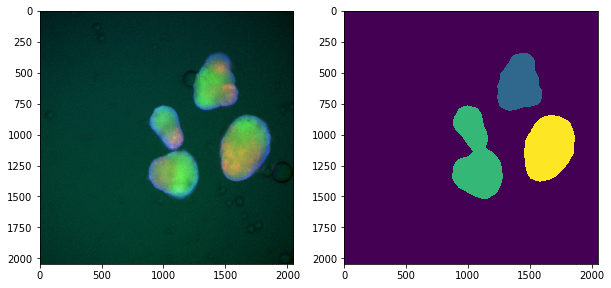

2 after filtering
2 after filtering
2 after filtering
MAL 476.3633960441524, ecc 0.6699504946791014
MAL 555.2292799551585, ecc 0.7116636982699971
Field of view 2
5 regions


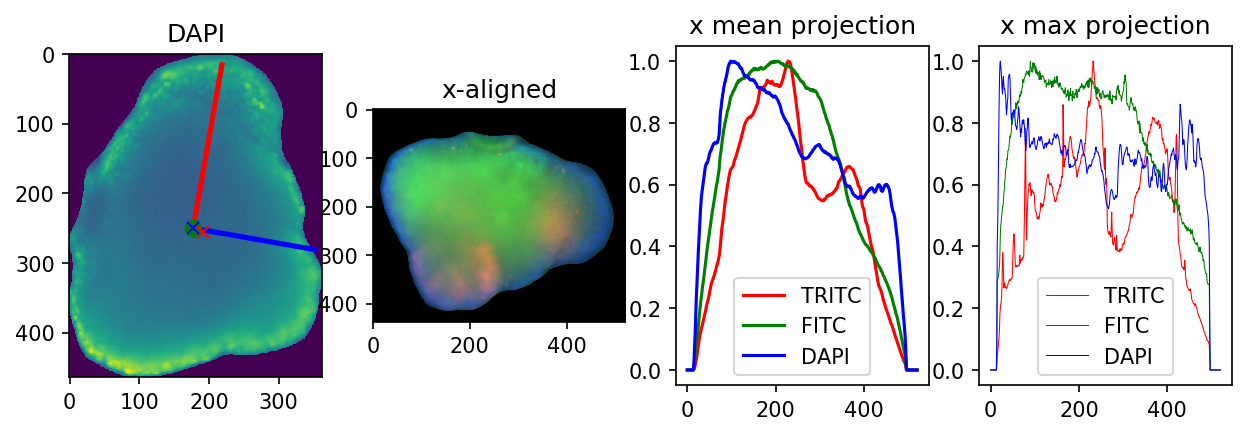

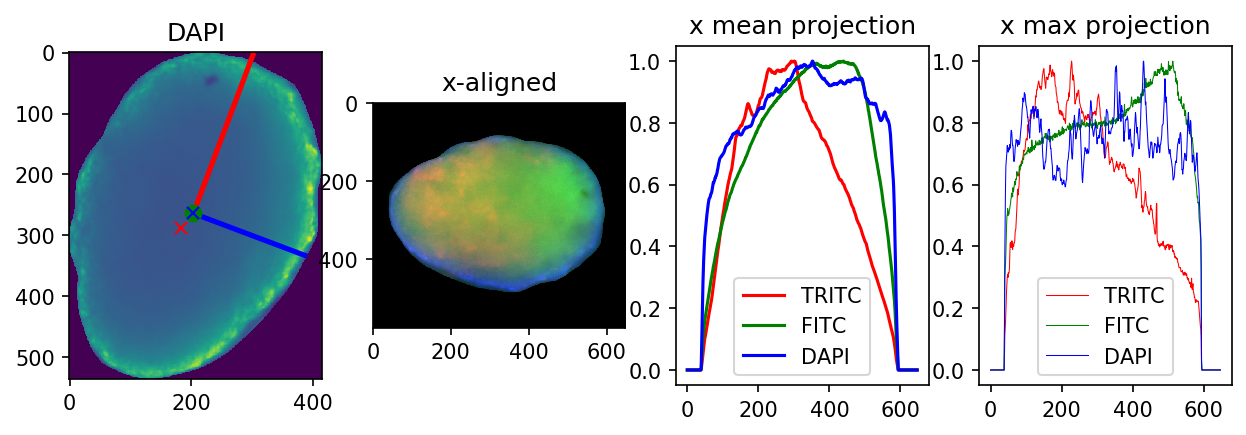

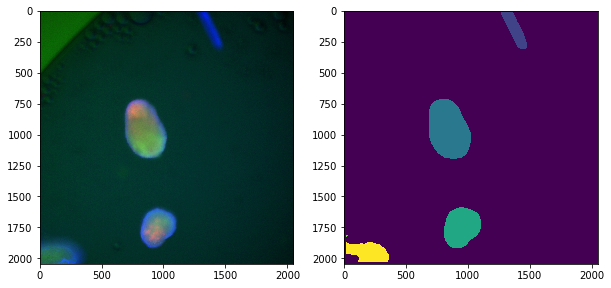

2 after filtering
2 after filtering
2 after filtering
MAL 508.9015864625201, ecc 0.7707228793807227
MAL 347.1494245878248, ecc 0.5892010452302452
Field of view 3
5 regions


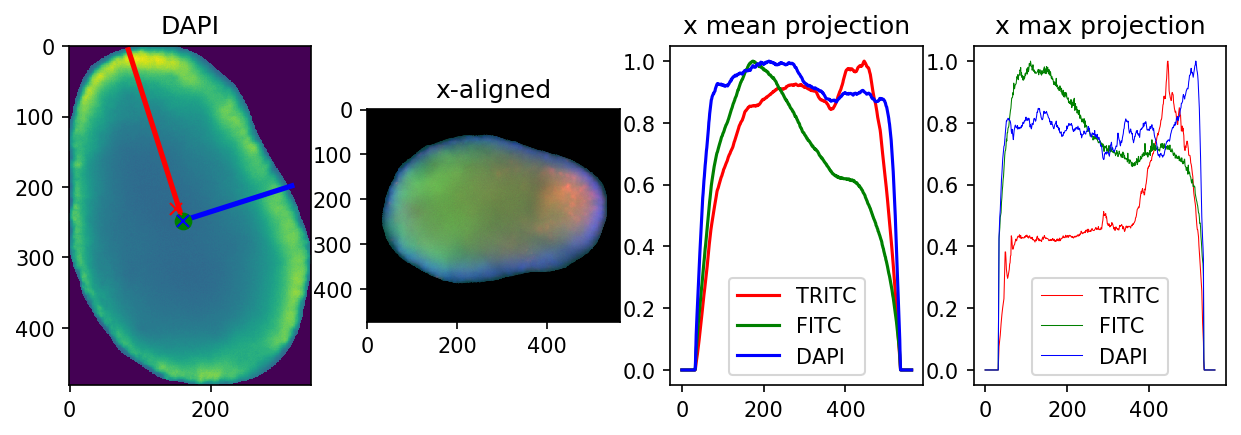

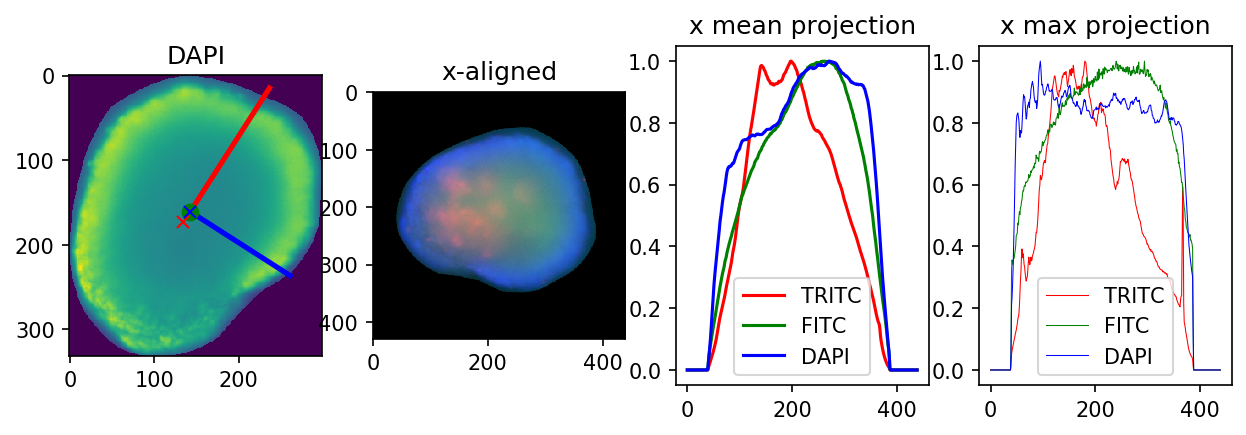

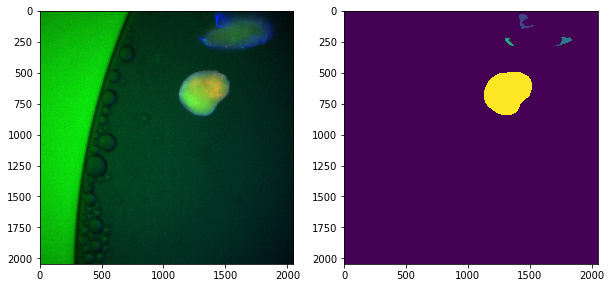

1 after filtering
1 after filtering
1 after filtering
MAL 404.5591700143066, ecc 0.5922370293260343
Field of view 4
1 regions


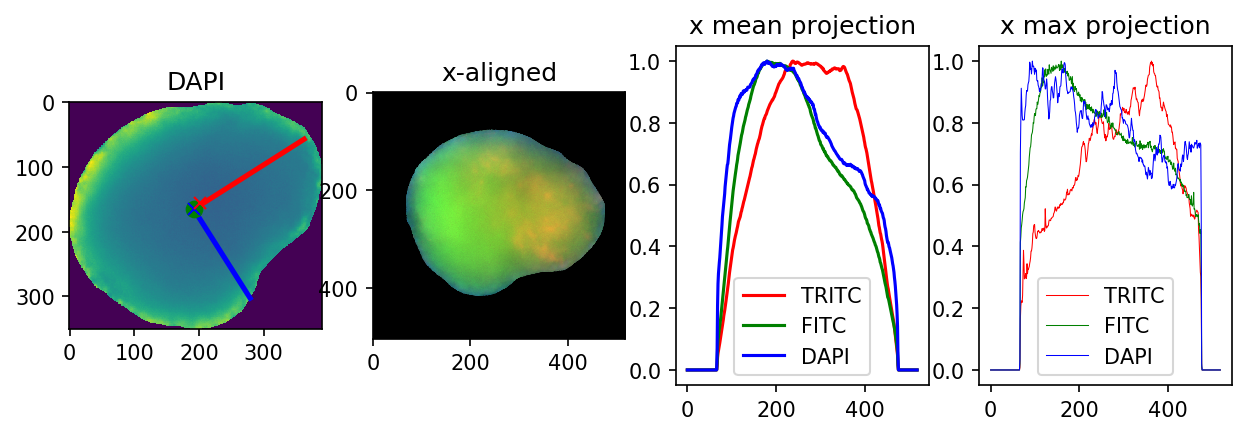

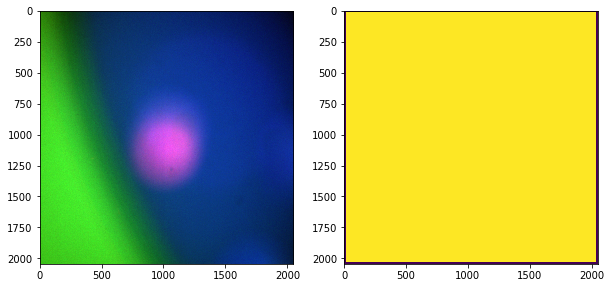

0 after filtering
0 after filtering
0 after filtering
Field of view 5
1 regions


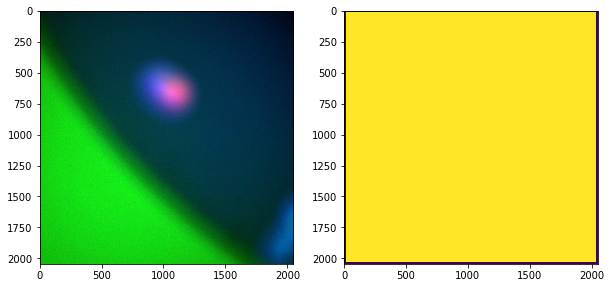

0 after filtering
0 after filtering
0 after filtering
Field of view 6
14 regions


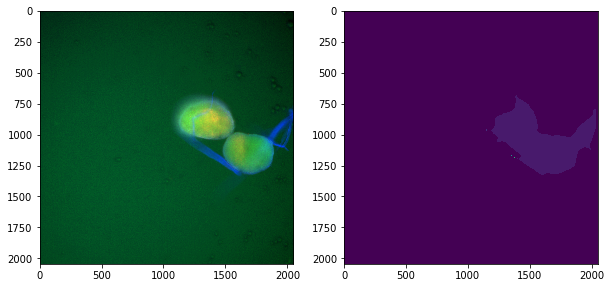

0 after filtering
0 after filtering
0 after filtering
Field of view 7
14 regions


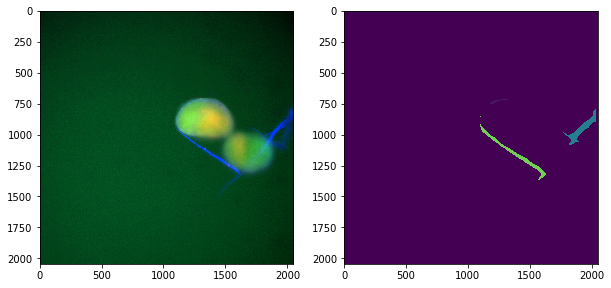

0 after filtering
0 after filtering
0 after filtering
Field of view 8
7 regions


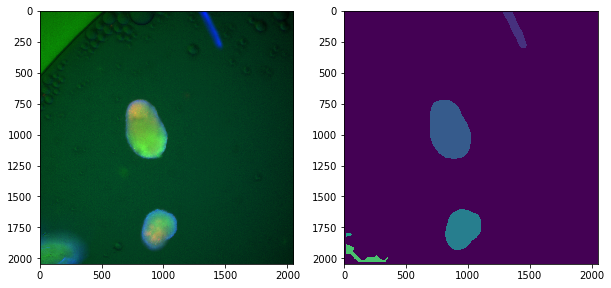

2 after filtering
2 after filtering
2 after filtering
MAL 501.45720955763915, ecc 0.7736063195664731
MAL 343.1232805515898, ecc 0.6143762335628465


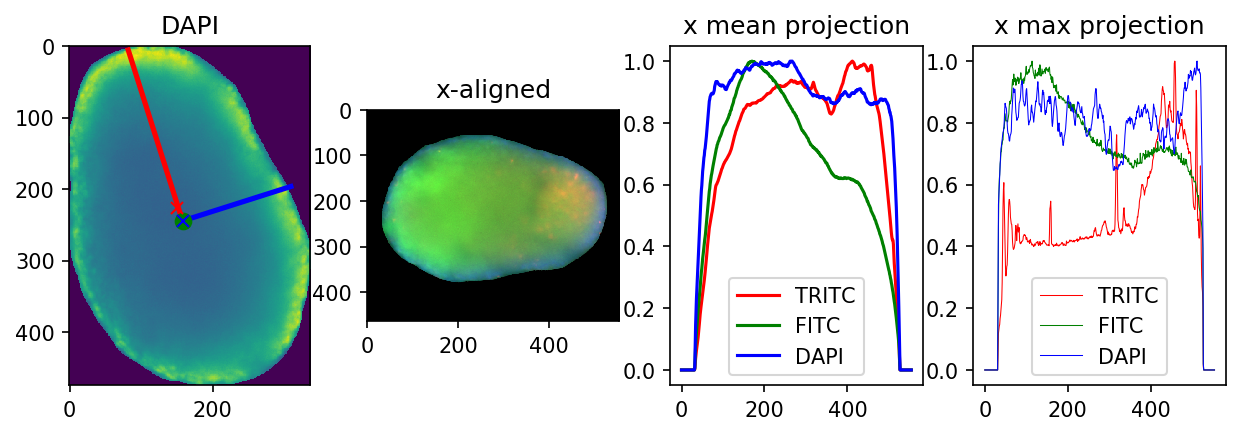

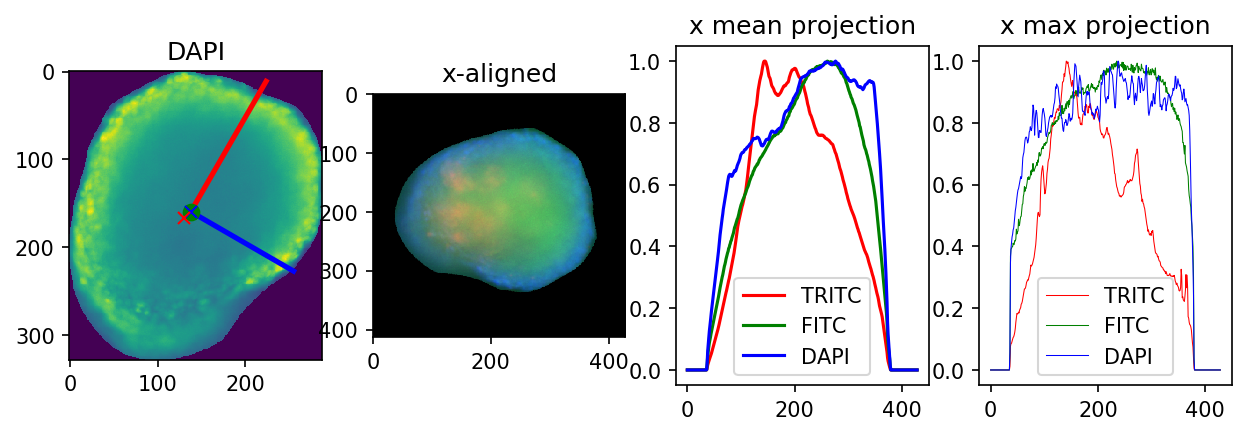

In [335]:
result = {'FOVs': {}}
for i, w in enumerate(well):
    print(f'Field of view {i+1}')
    result['FOVs'][i] = segment_multichannel(w)


In [336]:

def convert(o):
    if isinstance(o, np.float16):
        return float(o)
    else:
        return 0
with open(fluo_path.replace('.nd2', '_profiles.json'), 'w') as fp:
    json.dump(result, fp, default=convert)

In [15]:
result_8001 = json.load(open(fluo_path_8001.replace('.nd2', '_profiles.json')))
result_1_2 = json.load(open(fluo_path_1_2.replace('.nd2', '_profiles.json')))

In [13]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d as gf

def subsample_intensity_profile(values, n_samples=10, sigma=10, plot=False):
    '''
    Subsamples 1D curve.
    1. Cut off zero values
    2. Smooth with `sigma`
    3. Intepolate using vector with `n_samples` spots
    
    Return:
    -------
    Subsampled values
    '''
    r_profile = np.array(values, 'float')
    rf_profile = r_profile[r_profile > 0]
    rfs_profile = gf(rf_profile, sigma)
    full_vector = np.arange(len(rfs_profile))
    approx = interp1d(full_vector, rfs_profile)
    vector = np.linspace(0, len(rfs_profile)-1, n_samples, endpoint=True)
    subsample = approx(vector)
    
    if plot:
        plt.plot(rf_profile)
        plt.plot(rfs_profile)
        plt.plot(vector, subsample, '.r')
    
    return subsample

array([0.13611052, 0.34051499, 0.47922164, 0.59767665, 0.74888387,
       0.36221044, 0.51177683, 0.63576341, 0.26357955, 0.08715156])

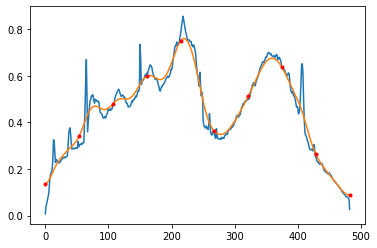

In [233]:
subsample_intensity_profile(r_profile, plot=1)

In [11]:
def orient(curve, color):
    curve = curve / curve.max()
    mid = len(curve) // 2
    if color == 'r':
        if curve.argmax() < mid:
            return curve[::-1], 'm'
        return curve, 'm'
    elif color == 'g':
        if curve.argmax() > mid:
            return curve[::-1], 'c'
        return curve, 'c'
    else:
        raise ValueError(f'expected color "r" or "g", got {color}')

In [16]:
binned_profiles_1_2 = [{c: orient(subsample_intensity_profile(o['intensity_profiles'][c]['max'], n_samples=21), c)[0] for c in 'rg'} 
                   for f in result_1_2['FOVs'].values() 
                   for o in f['organoids'].values() 
                  ]

In [17]:
binned_profiles_8001 = [{c: orient(subsample_intensity_profile(o['intensity_profiles'][c]['max'], n_samples=21), c)[0] for c in 'rg'} 
                   for f in result_8001['FOVs'].values() 
                   for o in f['organoids'].values() 
                  ]

In [18]:
binned_profiles_8001

[{'r': array([0.11517306, 0.19535708, 0.31161133, 0.55601143, 0.76231765,
         0.89038052, 0.7982911 , 0.62062225, 0.4829611 , 0.49090515,
         0.79832109, 1.        , 0.80633855, 0.79187656, 0.71132925,
         0.66338484, 0.60276771, 0.60613016, 0.41748942, 0.32372946,
         0.1798736 ]),
  'g': array([0.4006876 , 0.69535753, 0.90368157, 1.        , 0.99817754,
         0.97172804, 0.95561667, 0.93150306, 0.95281125, 0.95943436,
         0.92962863, 0.926423  , 0.93050563, 0.86506732, 0.75940044,
         0.67778828, 0.60505229, 0.5429622 , 0.47304775, 0.40264228,
         0.30694044])},
 {'r': array([0.18114983, 0.28257496, 0.34462992, 0.41071025, 0.43679247,
         0.525235  , 0.60106781, 0.64661908, 0.69453515, 0.71691384,
         0.81767252, 0.88321305, 0.89102515, 0.97306617, 0.89774127,
         0.99096613, 1.        , 0.90990656, 0.75270503, 0.48251311,
         0.25642826]),
  'g': array([0.48381645, 0.74700714, 0.89101084, 0.99890139, 1.        ,
         0.97

In [20]:
binned_profiles_1_2

[{'r': array([0.27814794, 0.47238636, 0.62373224, 0.68121446, 0.7584088 ,
         0.83061079, 0.92382195, 0.99964861, 0.98817793, 0.91437233,
         0.88492164, 0.87153787, 0.92444247, 1.        , 0.94243638,
         0.82106158, 0.72073459, 0.66133197, 0.58401714, 0.45729751,
         0.34984929]),
  'g': array([0.32927519, 0.54646136, 0.72511778, 0.79775001, 0.85771956,
         0.90654624, 0.93782109, 0.95810261, 0.98201641, 1.        ,
         0.98734679, 0.95699158, 0.94024805, 0.93120794, 0.91612318,
         0.85751578, 0.78935762, 0.71583681, 0.62024837, 0.49810287,
         0.40983421])},
 {'r': array([0.05301579, 0.10294638, 0.15549329, 0.19617033, 0.21535618,
         0.22429184, 0.22938675, 0.2336947 , 0.23859781, 0.23827956,
         0.23926848, 0.27252549, 0.38050313, 0.47832145, 0.54066964,
         0.65160616, 1.        , 0.83795829, 0.52014337, 0.4013632 ,
         0.25084703]),
  'g': array([0.32670662, 0.5838888 , 0.7967439 , 0.94052324, 1.        ,
         0.99

In [21]:
import pandas as pd

def _to_channel(color):
    if color == 'r':
        return 'TRITC'
    elif color == 'g':
        return 'FITC'
    else:
        raise ValueError(f'r or g only, got {color}')

def to_df(index, color, vector, curve, prefix=''):
    l = len(vector)
    assert (l := len(vector)) == len(curve)
    df = pd.DataFrame(data={'id': f'{prefix}_{index}', 'color': _to_channel(color), 'major axis': vector, 'normalized intensity': curve})
    return df

In [22]:
def get_vector(curve):
    return np.linspace(-0.5, 0.5, num=len(curve))

In [23]:
def profile_to_df(index:int, color_profile:dict, prefix=None):
    dfs = []
    for c, profile in color_profile.items():
        dfs.append(to_df(index, c, get_vector(profile), profile, prefix))
    return pd.concat(dfs)

In [33]:
dfs_1_2 = reduce(
    lambda a, b: pd.concat([a,b], ignore_index=True), 
    map(
        lambda bp: profile_to_df(*bp, prefix='1-2'), 
        enumerate(binned_profiles_1_2)
    )
)

In [34]:
dfs_8001 = reduce(
    lambda a, b: pd.concat([a,b], ignore_index=True), 
    map(
        lambda bp: profile_to_df(*bp, prefix='8001'), 
        enumerate(binned_profiles_8001)
    )
)

In [31]:
dfs_8001

,id,color,major axis,normalized intensity
0,8001_0,TRITC,-0.50,0.115173
1,8001_0,TRITC,-0.45,0.195357
2,8001_0,TRITC,-0.40,0.311611
3,8001_0,TRITC,-0.35,0.556011
4,8001_0,TRITC,-0.30,0.762318
...,...,...,...,...
289,8001_6,FITC,0.30,0.758559
290,8001_6,FITC,0.35,0.689855
291,8001_6,FITC,0.40,0.613334
292,8001_6,FITC,0.45,0.489149


In [32]:
dfs

,id,color,major axis,normalized intensity
0,1-2_0,TRITC,-0.50,0.278148
1,1-2_0,TRITC,-0.45,0.472386
2,1-2_0,TRITC,-0.40,0.623732
3,1-2_0,TRITC,-0.35,0.681214
4,1-2_0,TRITC,-0.30,0.758409
...,...,...,...,...
499,1-2_11,FITC,0.30,0.712892
500,1-2_11,FITC,0.35,0.692039
501,1-2_11,FITC,0.40,0.643115
502,1-2_11,FITC,0.45,0.546915


In [35]:
dfs_1_2.to_json(fluo_path_1_2.replace('.nd2', '_binned_profiles.json') )

In [36]:
dfs_8001.to_json(fluo_path_8001.replace('.nd2', '_binned_profiles.json') )

In [384]:
dfs.values.shape

(504, 4)

In [385]:
import seaborn as sns

Text(0.5, 1.0, '1-2')

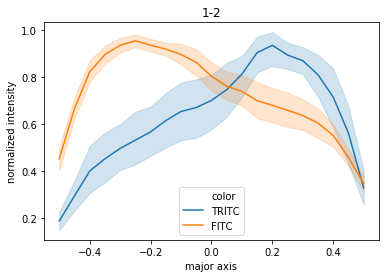

In [400]:
sns.lineplot(x='major axis', y='normalized intensity', hue='color', data=dfs)
plt.title('1-2')

Text(0.5, 1.0, '8001')

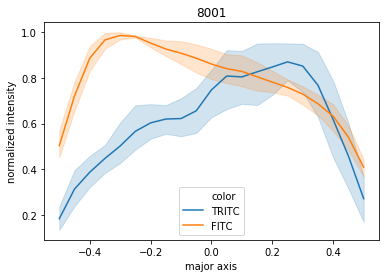

In [401]:
sns.lineplot(x='major axis', y='normalized intensity', hue='color', data=dfs_8001)
plt.title('8001')

Text(0.5, 1.0, '8001')

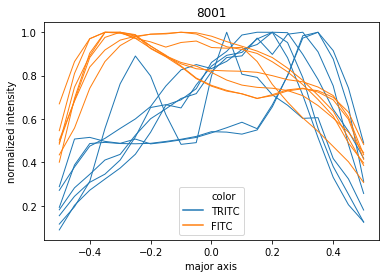

In [402]:
sns.lineplot(x='major axis', y='normalized intensity', hue='color', units='id', data=dfs_8001, estimator=None, lw=1,)
plt.title('8001')

In [403]:
dfs_both = pd.concat([dfs, dfs_8001])
dfs_both.shape

(798, 4)

Text(0.5, 1.0, '`1-2` + `8001`')

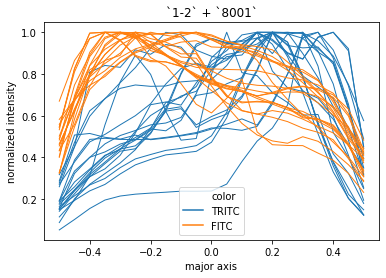

In [404]:
sns.lineplot(x='major axis', y='normalized intensity', hue='color', units='id', data=dfs_both, estimator=None, lw=1,)
plt.title('`1-2` + `8001`')

Text(0.5, 1.0, '`1-2` + `8001`, 16 samples')

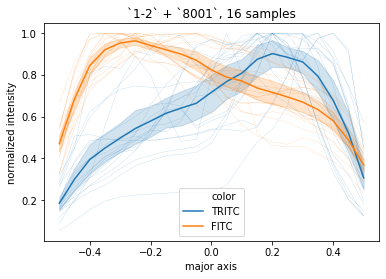

In [409]:
sns.lineplot(x='major axis', y='normalized intensity', hue='color', units='id', data=dfs_both, estimator=None, lw=.1,)
sns.lineplot(x='major axis', y='normalized intensity', hue='color',data=dfs_both, legend=None)
plt.title('`1-2` + `8001`, 16 samples')

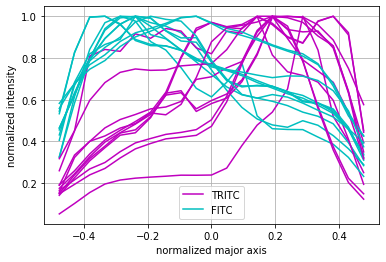

In [410]:
_ = [plt.plot((np.arange(len(p)) - len(p) // 2) / len(p) , *orient(p, c)) for bp in binned_profiles[1:] for c, p in bp.items() ]
plt.xlabel('normalized major axis')
plt.ylabel('normalized intensity')
plt.legend(['TRITC', 'FITC'])
plt.grid()

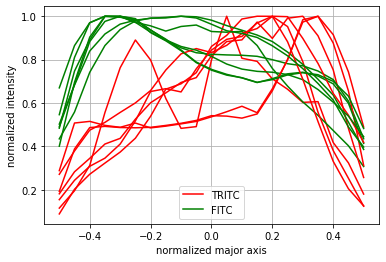

In [411]:
for bp in binned_profiles_8001[:]:
    for c, p in bp.items():
        try:
            _ = plt.plot(get_vector(p) , p, c) 
        except Exception as e:
            print(get_vector(p) , p, c)
            raise(e)
plt.xlabel('normalized major axis')
plt.ylabel('normalized intensity')
plt.legend(['TRITC', 'FITC'])
plt.grid()